# Resumo da Estrategia

Este notebook apresenta um **pipeline de classificação baseada em *One-Class Learning (OCL)*** para o problema de identificação de afinidade entre **temas estratégicos** e **perfis acadêmicos**.

O objetivo principal é **reduzir o custo computacional** do processo de classificação, atuando como um **filtro eficiente** antes de enviar os pares para modelos mais potentes (como LLMs).

---

## Etapa 1: Formulação da Tarefa

* **Classe de interesse:** `ALTA` afinidade.
* **Outliers:** `BAIXA` afinidade.

**Motivação para o One-Class Learning (OCL):**

* Mais fácil mapear o que tem **alta afinidade** do que definir todas as possibilidades de "não afinidade".
* Cada tema possui **particularidades próprias**, justificando um classificador específico por tema.
* Se faltarem exemplos de afinidade alta para um tema, usamos:

  * O **tema** em si,
  * Suas **palavras-chave**,
  * Exemplos disponíveis de **alta afinidade**.

**Resumo:** O OCL atua como um filtro de baixo custo, selecionando candidatos promissores que serão posteriormente avaliados por classificadores mais robustos (LLMs).

---

## Etapa 2: Geração de Embeddings Semânticos

Utilizaremos **modelos de embeddings de última geração** para representar semanticamente os temas e perfis:

* `BAAI/bge-m3`
* `intfloat/multilingual-e5-large`
* `ibm-granite/granite-embedding-278m-multilingual`

**Motivação:**

* São modelos **recentes e robustos**, já avaliados com bons resultados em tarefas de similaridade semântica.
* Permitirão comparar qual embedding funciona melhor no papel de filtro OCL.

---

## Etapa 3: Projeção e Interpretabilidade (t-SNE)

Após gerar os embeddings, aplicamos **t-SNE** para projetar os vetores em **2D** e tornar os resultados interpretáveis.

**Objetivos da projeção:**

* Visualizar como os dados se agrupam.
* Entender o **motivo de determinada classificação**.
* Aumentar a transparência no processo, essencial quando lidamos com **temas estratégicos** e **currículos de pesquisadores**.

---

## Etapa 4: Classificação com One-Class Learning

1. **Treinamento:**

   * Usamos os embeddings dos **temas**, **palavras-chave** e **perfis com afinidade alta** para aprender uma **região de interesse** no espaço 2D.
   * O OCL cria algo equivalente a um **"círculo de afinidade"**.

2. **Inferência:**

   * Novos pesquisadores são mapeados no embedding space.
   * O filtro OCL verifica se eles estão **dentro da área de interesse**.
   * Se sim ➝ enviados para o **classificador potente (LLM)**.

**Vantagens:**

* Baixo custo de **tempo e memória**.
* Reduz o número de chamadas a LLMs.
* Permite foco em **casos mais promissores de afinidade**.

# Download de arquivos com as embedings

In [ ]:
!gdown 12H957uf6mK-1X_ztT9hgFS1slpN2j-Wh
!gdown 1-QXkqH8HzLcV2JCA4Nm9G5rQhorYKJVe
!gdown 1JsC8Hk4qXU_OmTgroQzuW9Gt7RVllYyP
!gdown 1kvuLdCd2dqDmGfHbthxwmZiKEqV2mJM4
!gdown 1bAMjDwJggPsM_2ZC6rPZ-PkGO6H1Qcpb
!gdown 1AOfwGyiyvc11tljXSvB1WwZW_5QEcLTa
!gdown 1SSketU72-HTBBimY4tw4fgCEcbPJ0gQ5
!gdown 19-UsvzbSH7KpTV60105q9xxd7AU_jSc7

In [ ]:
!pip install codecarbon

In [1]:
import pandas as pd
dados_df = pd.read_parquet('leandl_oesnpg_dicionario.parquet')

# Train-Test and OCL Classification

In [2]:
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report
from sklearn.svm import OneClassSVM as OCSVM
import numpy as np
from tqdm import tqdm
from codecarbon import EmissionsTracker
from sklearn.exceptions import UndefinedMetricWarning
import warnings
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)

def train_test(X_embedded, embs_KW, df_cv_tema):
    X_embedded_train = X_embedded[:len(embs_KW[0])+1] # embeddings do tema e paalvras chave sempre sao treino
    X_embedded_test = X_embedded[len(embs_KW[0])+1:] # embeddings de curriculos
    df_cv_tema['emb_CV2d'] = pd.Series(list(X_embedded_test), index=df_cv_tema.index)
    X_embedded_int = df_cv_tema[df_cv_tema.modelo_nivel != 'BAIXA'].emb_CV2d.to_list() # afinidades alta
    X_embedded_train_int = X_embedded_int[:int(len(X_embedded_int)/2)] # afinidades alta treino
    X_embedded_test_int = X_embedded_int[int(len(X_embedded_int)/2):] # afinidades alta teste
    X_embedded_test_out = df_cv_tema[df_cv_tema.modelo_nivel == 'BAIXA'].emb_CV2d.to_list() # afinidades baixa
    return X_embedded_train, X_embedded_train_int, X_embedded_test_int, X_embedded_test_out

def classification(X_embedded, nu, embs_KW, df_cv_tema):
    X_embedded_train, X_embedded_train_int, X_embedded_test_int, X_embedded_test_out = train_test(X_embedded, embs_KW, df_cv_tema)
    ocsvm = OCSVM(kernel='rbf', nu=nu)
    if len(X_embedded_train_int) > 0: # verifica se tem afinidade alta pra treinar
        ocsvm.fit(np.concatenate([X_embedded_train, X_embedded_train_int]))
    else:
        ocsvm.fit(X_embedded_train)

    if len(X_embedded_test_int) > 0: # verifica se tem afinidade alta pra predizer
        y_pred_int = ocsvm.predict(X_embedded_test_int)
    else:
        y_pred_int = []

    if len(X_embedded_test_out) > 0:  # verifica se tem afinidade baixa pra predizer
        y_pred_out = ocsvm.predict(X_embedded_test_out)
    else:
        y_pred_out = []

    f1_macro = classification_report(np.concatenate([y_pred_int, y_pred_out]), np.concatenate([[1] * len(y_pred_int), [-1] * len(y_pred_out)]), output_dict=True)['macro avg']['f1-score']
    return ocsvm, f1_macro

def execution(column='emb_CV'):
  df_results = pd.DataFrame({'nu-0.1': [{}, {}, {}], 'nu-0.2': [{}, {}, {}], 'nu-0.3': [{}, {}, {}], 'nu-0.4': [{}, {}, {}], 'nu-0.5': [{}, {}, {}]}, index=['bge-m3', 'e5', 'ibm'])
  df_carbon = pd.DataFrame({'nu-0.1': [{}, {}, {}], 'nu-0.2': [{}, {}, {}], 'nu-0.3': [{}, {}, {}], 'nu-0.4': [{}, {}, {}], 'nu-0.5': [{}, {}, {}]}, index=['bge-m3', 'e5', 'ibm'])
  for name in ['bge-m3', 'e5', 'ibm']:
      meu_df = pd.read_pickle('df_' +name+'.pkl')
      df_temas = pd.read_pickle('temas_'+name+'.pkl')
      for tema_id in tqdm(df_temas.tema_id.unique()):
          df_cv_tema = meu_df[(meu_df.tema_id == tema_id) & ((meu_df.modelo_nivel == 'ALTA') | (meu_df.modelo_nivel == 'BAIXA'))].copy()
          emb_tema = df_temas[df_temas.tema_id == tema_id].emb_tema.to_list()
          embs_KW = df_temas[df_temas.tema_id == tema_id].embs_KW.to_list()
          emb_CV = df_cv_tema[column].to_list()

          reducer_tsne = TSNE(perplexity=30 if len(emb_CV) > 30 else len(embs_KW[0]),random_state=81, metric='cosine')
          if len(emb_CV) > 0:
              X_embedded = reducer_tsne.fit_transform(np.concatenate([emb_tema, embs_KW[0], emb_CV]))
          else:
              X_embedded = reducer_tsne.fit_transform(np.concatenate([emb_tema, embs_KW[0]]))

          for nu in [0.1, 0.2, 0.3, 0.4, 0.5]:
              tracker = EmissionsTracker(project_name=name+'_'+str(tema_id)+'_'+str(nu), log_level="error")
              tracker.start()
              ocsvm, f1 = classification(X_embedded, nu, embs_KW, df_cv_tema)
              emissions: float = tracker.stop()

              df_results.at[name,'nu-'+str(nu)][str(tema_id)] = f1
              df_carbon.at[name,'nu-'+str(nu)][str(tema_id)] = emissions

  return df_results, df_carbon

def resume_results(df):
  d = pd.DataFrame({'nu-0.1': [{}, {}, {}], 'nu-0.2': [{}, {}, {}], 'nu-0.3': [{}, {}, {}], 'nu-0.4': [{}, {}, {}], 'nu-0.5': [{}, {}, {}]}, index=['bge-m3', 'e5', 'ibm'])
  for name in ['bge-m3', 'e5', 'ibm']:
      for nu in [0.1, 0.2, 0.3, 0.4, 0.5]:
          df_r_aux = pd.Series(df.at[name,'nu-'+str(nu)])
          df_r_aux = df_r_aux.dropna()
          d.at[name,'nu-' + str(nu)] = np.mean(df_r_aux.values)
  return d

# Resultados

In [ ]:
df_result_resumo, df_carbon_resumo  = execution(column='emb_CV')

100%|██████████| 458/458 [1:15:36<00:00,  9.91s/it]


In [ ]:
df_result_titulo, df_carbon_titulo = execution(column='emb_titulo')

100%|██████████| 458/458 [1:04:38<00:00,  8.47s/it]


In [ ]:
pd.set_option("display.float_format", "{:.4}".format)
resume_results(df_result_resumo)

,nu-0.1,nu-0.2,nu-0.3,nu-0.4,nu-0.5
bge-m3,0.6277,0.6293,0.6059,0.5833,0.5605
e5,0.6082,0.5992,0.601,0.5744,0.5567
ibm,0.6208,0.6356,0.6235,0.5956,0.5607


In [ ]:
pd.set_option("display.float_format", "{:.2e}".format)
resume_results(df_carbon_resumo)

,nu-0.1,nu-0.2,nu-0.3,nu-0.4,nu-0.5
bge-m3,5.20e-08,5.36e-08,5.38e-08,5.17e-08,5.33e-08
e5,4.99e-08,4.95e-08,4.97e-08,4.91e-08,4.91e-08
ibm,4.94e-08,4.81e-08,4.95e-08,4.84e-08,4.89e-08


In [ ]:
pd.set_option("display.float_format", "{:.4}".format)
resume_results(df_result_titulo)

,nu-0.1,nu-0.2,nu-0.3,nu-0.4,nu-0.5
bge-m3,0.6103,0.6013,0.5801,0.5501,0.532
e5,0.592,0.5843,0.5719,0.5441,0.5341
ibm,0.6047,0.5987,0.5945,0.5708,0.5526


In [ ]:
pd.set_option("display.float_format", "{:.2e}".format)
resume_results(df_carbon_titulo)

,nu-0.1,nu-0.2,nu-0.3,nu-0.4,nu-0.5
bge-m3,3.75e-08,3.76e-08,3.91e-08,3.84e-08,3.79e-08
e5,3.67e-08,3.59e-08,3.61e-08,3.56e-08,3.62e-08
ibm,3.66e-08,3.57e-08,3.63e-08,3.61e-08,3.60e-08


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df_r_aux = pd.Series(df_result_resumo.at['ibm','nu-0.2'])
df_r_aux = df_r_aux.dropna()

import numpy as np
df = pd.DataFrame({
    "f1_score": df_r_aux
})

plt.figure(figsize=(8, 5))
plt.hist(df["f1_score"], bins=20, edgecolor="black", alpha=0.7)
plt.xlabel("f1-score")
plt.ylabel("Frequency")
plt.title("f1-score distribution")
plt.grid(True, linestyle="--", alpha=0.6)
plt.savefig('f1-ocsvm.png')

# Interpretabilidade

In [8]:
import matplotlib.pyplot as plt

def plot(emb, tema_id, nu, l):

    meu_df = pd.read_pickle('df_'+emb+'.pkl')
    df_temas = pd.read_pickle('temas_'+emb+'.pkl')
    df_cv_tema = meu_df[(meu_df.tema_id == tema_id) & ((meu_df.modelo_nivel == 'ALTA') | (meu_df.modelo_nivel == 'BAIXA'))].copy()
    emb_tema = df_temas[df_temas.tema_id == tema_id].emb_tema.to_list()
    embs_KW = df_temas[df_temas.tema_id == tema_id].embs_KW.to_list()
    emb_CV = df_cv_tema.emb_CV.to_list()

    reducer_tsne = TSNE(perplexity=30 if len(emb_CV) > 30 else len(embs_KW[0]),random_state=81, metric='cosine')
    if len(emb_CV) > 0:
        X_embedded = reducer_tsne.fit_transform(np.concatenate([emb_tema, embs_KW[0], emb_CV]))
    else:
        X_embedded = reducer_tsne.fit_transform(np.concatenate([emb_tema, embs_KW[0]]))

    ocsvm, f1 = classification(X_embedded, nu, embs_KW, df_cv_tema)
    print(f1)

    X_embedded_train, X_embedded_train_int, X_embedded_test_int, X_embedded_test_out = train_test(X_embedded, embs_KW, df_cv_tema)

    limite_n_x = X_embedded[:,0].min() - l
    limite_n_y = X_embedded[:,1].min() - l

    limite_p_x = X_embedded[:,0].max() + l
    limite_p_y = X_embedded[:,1].max() + l

    fig = plt.figure(figsize=(10, 7))

    if len(X_embedded_test_out) > 0:
        plt.scatter(np.array(X_embedded_test_out)[:, 0], np.array(X_embedded_test_out)[:, 1], c='green', s=70, edgecolors='k') # afinidade não ALTA

    plt.scatter(np.array([X_embedded_train[0]])[:, 0], np.array([X_embedded_train[0]])[:, 1], c='darkblue', s=70, edgecolors='k') #tema
    plt.scatter(np.array(X_embedded_train[1:])[:, 0], np.array(X_embedded_train[1:])[:, 1], c='blue', s=70, edgecolors='k') #palavras chave

    if len(X_embedded_test_int) > 0:
        plt.scatter(np.array(X_embedded_test_int)[:, 0], np.array(X_embedded_test_int)[:, 1], c='pink', s=70, edgecolors='k') # afinidade ALTA

    if len(X_embedded_train_int) > 0:
        plt.scatter(np.array(X_embedded_train_int)[:, 0], np.array(X_embedded_train_int)[:, 1], c='purple', s=70, edgecolors='k') #palavras chave

    xx, yy = np.meshgrid(np.linspace(limite_n_x, limite_p_x, 500), np.linspace(limite_n_y, limite_p_y, 500))

    Z = ocsvm.decision_function(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)

    plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='red') #esfera

    plt.xlim((limite_n_x, limite_p_x))
    plt.ylim((limite_n_y, limite_p_y))
    plt.savefig(emb + '_' + str(tema_id) + '.png')

### Escolha um:
 - ID de tema
 - modelo de embeddings
 - nu (suavização da area de interesse do tema, quanto maior mais restrito)

### O bloco de código abaixo ordena os temas pela F1 para possibilitar a exploração de casos ruins, médios e bons

In [ ]:
modelo = 'ibm'
nu = 0.2

df_r_aux = pd.Series(df_result_resumo.at[modelo,'nu-'+str(nu)])
df_r_aux = df_r_aux.dropna()
df_r_aux.sort_values()[40:60] # diminua para explorar casos ruins

0.42857142857142855


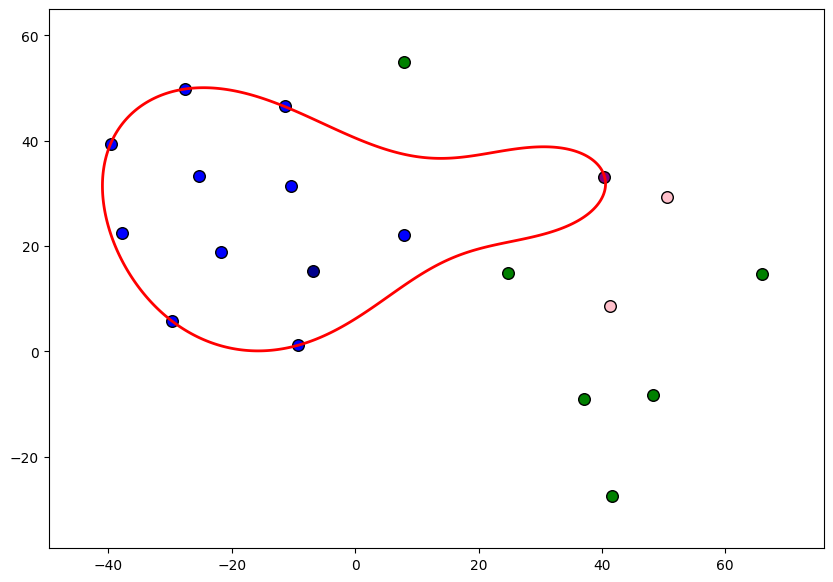

In [10]:
tema_id = 271
plot(modelo, tema_id, nu, 10)

# Baseline

## BERT Filter

E se usarmos uma estrategia de filtro por similaridade por tema, assim como o OCL, mas sem treinar um classificador, obteremos melhores resultados?

In [4]:
from sklearn.metrics.pairwise import cosine_distances
import numpy as np
from tqdm import tqdm
from sklearn.exceptions import UndefinedMetricWarning
import warnings
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)
from sklearn.metrics import classification_report

def execution_bert(column='emb_CV'):
  df_results = pd.DataFrame({'ts-0.1': [{}, {}, {}], 'ts-0.2': [{}, {}, {}], 'ts-0.3': [{}, {}, {}], 'ts-0.4': [{}, {}, {}], 'ts-0.5': [{}, {}, {}]}, index=['bge-m3', 'e5', 'ibm'])
  df_carbon = pd.DataFrame({'ts-0.1': [{}, {}, {}], 'ts-0.2': [{}, {}, {}], 'ts-0.3': [{}, {}, {}], 'ts-0.4': [{}, {}, {}], 'ts-0.5': [{}, {}, {}]}, index=['bge-m3', 'e5', 'ibm'])
  for name in ['bge-m3', 'e5', 'ibm']:
      meu_df = pd.read_pickle('df_' +name+'.pkl')
      df_temas = pd.read_pickle('temas_'+name+'.pkl')
      for tema_id in tqdm(df_temas.tema_id.unique()):
          df_cv_tema = meu_df[(meu_df.tema_id == tema_id) & ((meu_df.modelo_nivel == 'ALTA') | (meu_df.modelo_nivel == 'BAIXA'))].copy()
          emb_tema = np.array(df_temas[df_temas.tema_id == tema_id].emb_tema.to_list())

          df_int = df_cv_tema[df_cv_tema.modelo_nivel != 'BAIXA'] # afinidades alta
          df_train_int = df_int[:int(len(df_int)/2)] # afinidades alta treino
          df_test_int = df_int[int(len(df_int)/2):] # afinidades alta teste
          df_test_out = df_cv_tema[df_cv_tema.modelo_nivel == 'BAIXA'] # afinidades baixa

          df_cv_tema = pd.concat([df_test_int, df_test_out])
          emb_CV = df_cv_tema[column].to_list()

          if len(emb_CV) == 0:
            for ts in [0.1, 0.2, 0.3, 0.4, 0.5]:
              tracker = EmissionsTracker(project_name=name+'_'+str(tema_id)+'_'+str(ts), log_level="error")
              tracker.start()
              df_results.at[name,'ts-'+str(ts)][str(tema_id)] = np.nan
              emissions: float = tracker.stop()
              df_carbon.at[name,'ts-'+str(ts)][str(tema_id)] = emissions
          else:
            for ts in [0.1, 0.2, 0.3, 0.4, 0.5]:
              tracker = EmissionsTracker(project_name=name+'_'+str(tema_id)+'_'+str(ts), log_level="error")
              tracker.start()
              x0 = emb_tema.reshape(1, -1)
              cos_dist = cosine_distances(emb_tema, emb_CV).flatten()
              pred = np.where(cos_dist < ts, "ALTA", "BAIXA")
              f1 = classification_report(pred, df_cv_tema.modelo_nivel.to_list(), output_dict=True)['macro avg']['f1-score']

              emissions: float = tracker.stop()
              df_carbon.at[name,'ts-'+str(ts)][str(tema_id)] = emissions
              df_results.at[name,'ts-'+str(ts)][str(tema_id)] = f1

  return df_results, df_carbon

def resume_results(df):
  d = pd.DataFrame({'ts-0.1': [{}, {}, {}], 'ts-0.2': [{}, {}, {}], 'ts-0.3': [{}, {}, {}], 'ts-0.4': [{}, {}, {}], 'ts-0.5': [{}, {}, {}]}, index=['bge-m3', 'e5', 'ibm'])
  for name in ['bge-m3', 'e5', 'ibm']:
      for ts in [0.1, 0.2, 0.3, 0.4, 0.5]:
          df_r_aux = pd.Series(df.at[name,'ts-'+str(ts)])
          df_r_aux = df_r_aux.dropna()
          d.at[name,'ts-' + str(ts)] = df_r_aux.mean()
  return d

In [ ]:
r_bert_resumo, r_carbon_resumo = execution_bert(column='emb_CV')

100%|██████████| 458/458 [1:14:51<00:00,  9.81s/it]


In [5]:
r_bert_titulo, r_carbon_titulo = execution_bert(column='emb_titulo')

100%|██████████| 458/458 [1:06:26<00:00,  8.70s/it]


In [ ]:
pd.set_option("display.float_format", "{:.4}".format)
resume_results(r_bert_resumo)

,ts-0.1,ts-0.2,ts-0.3,ts-0.4,ts-0.5
bge-m3,0.4929,0.4929,0.4929,0.5118,0.5794
e5,0.4929,0.5231,0.1686,0.1686,0.1686
ibm,0.4929,0.4931,0.5314,0.5482,0.2256


In [6]:
pd.set_option("display.float_format", "{:.4}".format)
resume_results(r_bert_titulo)

,ts-0.1,ts-0.2,ts-0.3,ts-0.4,ts-0.5
bge-m3,0.4929,0.4929,0.4949,0.5261,0.5501
e5,0.4929,0.2174,0.1686,0.1686,0.1686
ibm,0.4929,0.4939,0.5119,0.5219,0.3139


In [ ]:
pd.set_option("display.float_format", "{:.2e}".format)
resume_results(r_carbon_resumo)

,ts-0.1,ts-0.2,ts-0.3,ts-0.4,ts-0.5
bge-m3,3.03e-08,2.94e-08,2.96e-08,2.94e-08,2.91e-08
e5,3.06e-08,2.99e-08,3.05e-08,3.00e-08,3.02e-08
ibm,2.93e-08,2.90e-08,2.89e-08,2.89e-08,2.89e-08


In [7]:
pd.set_option("display.float_format", "{:.2e}".format)
resume_results(r_carbon_titulo)

,ts-0.1,ts-0.2,ts-0.3,ts-0.4,ts-0.5
bge-m3,2.39e-08,2.31e-08,2.35e-08,2.31e-08,2.27e-08
e5,2.33e-08,2.31e-08,2.28e-08,2.31e-08,2.26e-08
ibm,2.25e-08,2.24e-08,2.27e-08,2.21e-08,2.21e-08


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df_r_aux = pd.Series(r_bert_resumo.at['bge-m3','ts-0.5'])
df_r_aux = df_r_aux.dropna()

import numpy as np
df = pd.DataFrame({
    "f1_score": df_r_aux
})

plt.figure(figsize=(8, 5))
plt.hist(df["f1_score"], bins=20, edgecolor="black", alpha=0.7)
plt.xlabel("f1-score")
plt.ylabel("Frequency")
plt.title("f1-score distribution")
plt.grid(True, linestyle="--", alpha=0.6)
plt.savefig('f1-bert')